## 태양광 LSTM/ 충전시간발전량 예측하기

In [1]:
# Dataset : 믿음태양광발전소 데이터 + 기상청데이터

In [2]:
# 충전시간발전량 : y
# 다른 특성은 : X
# 여러가지 feature 바탕으로 충전시간발전량 예측
# LSTM 활용 on keras


## 데이터 불러오기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sun_weather=pd.read_csv('sun_weather.csv')

In [5]:
sun_weather.head()

,날짜,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
0,160701,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,...,24.100000,23.6,24.299999,24.200001,24.700001,24.500000,24.200001,22.799999,22.400000,22.200001
1,160702,0.0,7.3,24.4,30.1,31.4,57.0,1.1,1.8,5.9,...,20.299999,21.0,21.000000,20.400000,20.400000,20.600000,19.900000,20.700001,20.100000,20.000000
2,160703,0.0,0.0,14.0,16.9,39.7,17.1,10.4,53.9,23.1,...,21.000000,21.4,21.700001,22.000000,22.100000,22.100000,22.200001,22.299999,22.200001,22.299999
3,160704,0.0,0.0,0.0,0.0,8.4,50.7,64.2,146.0,276.5,...,23.799999,23.6,23.600000,23.000000,22.900000,22.700001,22.700001,22.799999,22.600000,22.500000
4,160705,0.0,13.8,74.7,147.0,177.9,306.2,347.2,389.1,302.7,...,25.900000,25.6,24.900000,24.900000,24.500000,23.600000,24.400000,24.600000,24.500000,24.400000


In [6]:
sun_weather.shape

(382, 84)

In [7]:
#날짜 컬럼 date데이터로 변환
sun_weather['날짜'] = pd.to_datetime(sun_weather['날짜'], format='%y%m%d')

In [8]:
sun_weather.index = sun_weather['날짜']

In [9]:
del sun_weather['날짜']

In [10]:
sun_weather.head(1)

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,...,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,1.3,...,24.1,23.6,24.299999,24.200001,24.700001,24.5,24.200001,22.799999,22.4,22.200001


In [11]:
sun_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 382 entries, 2016-07-01 to 2017-07-17
Data columns (total 83 columns):
5Hr        382 non-null float64
6Hr        382 non-null float64
7Hr        382 non-null float64
8Hr        382 non-null float64
9Hr        382 non-null float64
10Hr       382 non-null float64
11Hr       382 non-null float64
12Hr       382 non-null float64
13Hr       382 non-null float64
14Hr       382 non-null float64
15Hr       382 non-null float64
16Hr       382 non-null float64
17Hr       382 non-null float64
18Hr       382 non-null float64
19Hr       382 non-null float64
20Hr       382 non-null int64
충전시간발전량    382 non-null float64
일출시간       382 non-null int64
일몰시간       382 non-null int64
강수량5hr     382 non-null float64
강수량6hr     382 non-null float64
강수량7hr     382 non-null float64
강수량8hr     382 non-null float64
강수량9hr     382 non-null float64
강수량10hr    382 non-null float64
강수량11hr    382 non-null float64
강수량12hr    382 non-null float64
강수량13hr    382 non

## EDA

In [12]:
#상식적으로 일출시간, 일몰시간이 발전량과 관계없을듯. 제거해보자
#또 다른 feature들이 outlier가 없는지 등등 확인해봐야지
#이 colum(feature)들이 RNN 알고리즘에 의해 Y값을 도출하는 데 모두 사용되니까. 하나하나 정말 필요한 컬럼인지 제대로 확인해야함
#또한, 시간대별로 나누는 것이 Y값을 도출하는 데 정말로 필요한 것일까? 차라리 시간을 묶어서 강수량, 습도량, 풍속 이렇게 묶는게 낫지 않을까?
#왜냐하면 Y값은 시간대별로 나뉘어져 있지 않기 때문이다. 
#만약 시간대별로 나뉘어져 있다면, dropout 할 때, 어떤 컬럼의 가중치는 무시될텐데. 그 컬럼이 가장 높은 강수량을 포함하는 컬럼이라면 
#발전량과의 관계를 효과적으로 나타내지 못할것같음

In [13]:
#위 처럼, 논리적으로 생각하는 방법도 있는 반면, 상관관계를 그래프로 나타내면서 필요없는 컬럼을 제거할 수 있다.

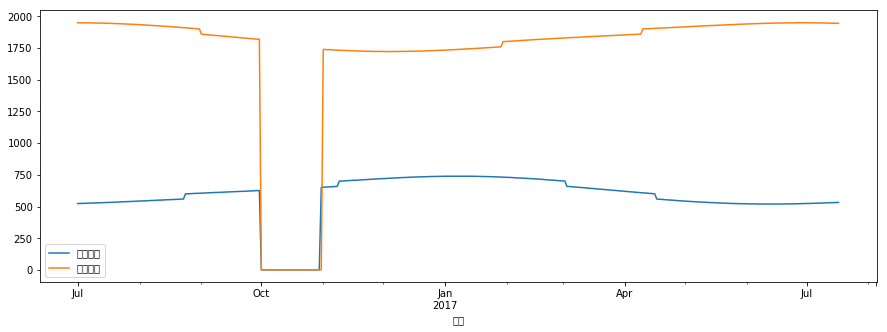

In [14]:
sun_weather[['일출시간', '일몰시간']].plot(figsize=(15,5))

In [15]:
del sun_weather['일출시간']

In [16]:
del sun_weather['일몰시간']

In [17]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [18]:
del sun_weather['20Hr']

In [19]:
sun_weather.corr()

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,충전시간발전량,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
5Hr,1.000000,0.321637,0.125692,0.102228,0.085458,0.076103,0.063280,0.042945,0.027075,0.004050,0.016920,0.012115,0.062369,0.085235,0.110729,0.039552,-0.013951,-0.011387,-0.015069,-0.015082,-0.015609,-0.014603,-0.012093,-0.010045,-0.012641,-0.016937,-0.009728,-0.009502,-0.016456,-0.011790,-0.015135,-0.013576,-0.016315,0.004890,0.007781,0.039047,0.039742,0.058670,0.052749,0.055084,0.068177,0.063705,0.077103,0.078967,0.083491,0.080590,0.081759,0.062145,0.004590,-0.024087,-0.075899,-0.070228,-0.061755,-0.056018,-0.060226,-0.047925,-0.049541,-0.051951,-0.023974,-0.058002,-0.067734,-0.077250,-0.066369,-0.048815,0.062948,0.056876,0.060709,0.055832,0.057665,0.056041,0.057843,0.062368,0.061920,0.063647,0.060250,0.060634,0.062023,0.061820,0.063865,0.067032
6Hr,0.321637,1.000000,0.765510,0.593065,0.436803,0.350309,0.334179,0.311095,0.288868,0.290360,0.311588,0.416703,0.550414,0.618461,0.296236,0.351790,-0.031821,-0.054394,-0.080487,-0.083992,-0.084283,-0.069409,-0.056162,-0.045488,-0.065868,-0.099251,-0.056440,-0.048916,-0.086930,-0.047844,-0.054986,-0.054777,-0.075077,-0.036625,-0.029709,0.000815,0.029372,0.048261,0.086212,0.094910,0.109310,0.112908,0.154504,0.172792,0.181355,0.200389,0.219721,0.230557,0.011829,-0.034493,-0.029607,-0.058819,-0.138225,-0.138531,-0.144183,-0.149557,-0.165567,-0.184442,-0.237420,-0.225716,-0.243281,-0.233458,-0.238729,-0.237151,0.398715,0.384992,0.377343,0.358119,0.346119,0.343609,0.330646,0.321645,0.312436,0.307713,0.296307,0.299478,0.295893,0.293181,0.288252,0.304097
7Hr,0.125692,0.765510,1.000000,0.883289,0.666345,0.522270,0.507636,0.487049,0.455320,0.461538,0.484375,0.615422,0.746237,0.666855,0.211939,0.541419,-0.090383,-0.074169,-0.104443,-0.118742,-0.136361,-0.109822,-0.093321,-0.084853,-0.102513,-0.077223,-0.062302,-0.061240,-0.047247,0.001706,0.006075,-0.005509,-0.072729,-0.035001,-0.022540,0.007681,0.050405,0.074161,0.126819,0.148406,0.165446,0.176912,0.218125,0.244089,0.266794,0.292060,0.315692,0.334170,0.000951,-0.040024,-0.030650,-0.075561,-0.217433,-0.190735,-0.231591,-0.238406,-0.283547,-0.295196,-0.360279,-0.342019,-0.349367,-0.337921,-0.340562,-0.314190,0.638226,0.622424,0.610195,0.589741,0.571089,0.559314,0.541367,0.528539,0.519931,0.516525,0.504281,0.501724,0.496027,0.493018,0.486356,0.500216
8Hr,0.102228,0.593065,0.883289,1.000000,0.844773,0.701040,0.669173,0.620102,0.598305,0.598733,0.602151,0.644708,0.696045,0.515660,0.129054,0.687913,-0.153955,-0.121893,-0.156757,-0.162453,-0.169072,-0.142532,-0.114493,-0.095666,-0.111695,-0.069227,-0.057458,-0.056532,-0.035045,0.006920,0.009961,0.005427,-0.253911,-0.219755,-0.202098,-0.164020,-0.102406,-0.075890,-0.022830,0.004371,0.032881,0.055944,0.093831,0.122503,0.146967,0.175999,0.196881,0.222117,0.046365,0.015389,0.013022,-0.063005,-0.239822,-0.187175,-0.222179,-0.222347,-0.273542,-0.287157,-0.340235,-0.328399,-0.339965,-0.329505,-0.334161,-0.311203,0.539866,0.526876,0.512009,0.485357,0.456857,0.438041,0.417457,0.404152,0.396464,0.391928,0.381383,0.376783,0.370883,0.370139,0.366201,0.376471
9Hr,0.085458,0.436803,0.666345,0.844773,1.000000,0.914032,0.852640,0.778510,0.748650,0.728646,0.674389,0.593946,0.536942,0.307895,0.005861,0.833801,-0.218082,-0.168907,-0.219792,-0.213525,-0.206364,-0.186188,-0.146612,-0.109217,-0.125075,-0.069827,-0.071977,-0.076413,-0.037633,-0.015597,-0.014112,-0.000417,-0.519017,-0.481758,-0.450930,-0.410784,-0.331365,-0.288101,-0.234375,-0.206233,-0.169927,-0.140540,-0.103836,-0.076527,-0.048738,-0.022433,-0

In [20]:
#위 데이터를 heatmap 그래프로 나타내보기
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

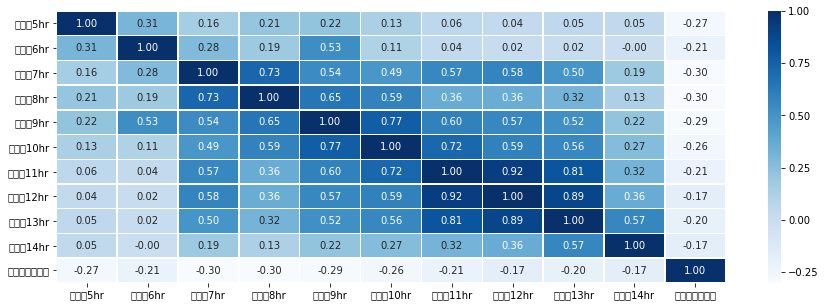

In [21]:
plt.figure(figsize=(15,5))
sns.heatmap(data=sun_weather[['강수량5hr', '강수량6hr', '강수량7hr', '강수량8hr', '강수량9hr',
       '강수량10hr', '강수량11hr', '강수량12hr', '강수량13hr', '강수량14hr','충전시간발전량']].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

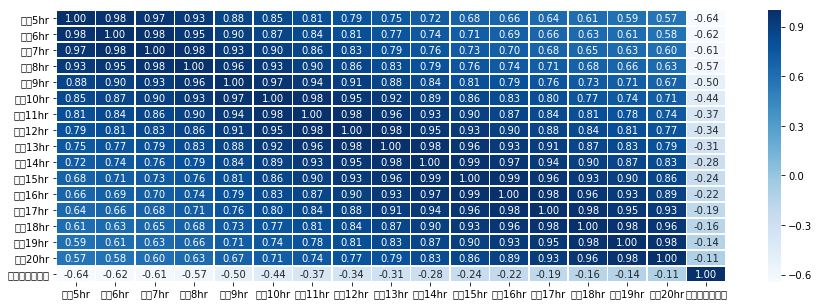

In [22]:
plt.figure(figsize=(15,5))
sns.heatmap(data=sun_weather[['습도5hr', '습도6hr',
       '습도7hr', '습도8hr', '습도9hr', '습도10hr', '습도11hr', '습도12hr', '습도13hr',
       '습도14hr', '습도15hr', '습도16hr', '습도17hr', '습도18hr', '습도19hr', '습도20hr','충전시간발전량']].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

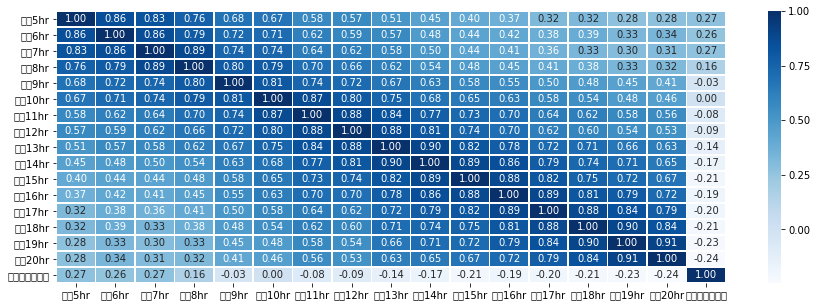

In [23]:
plt.figure(figsize=(15,5))
sns.heatmap(data=sun_weather[['풍속5hr', '풍속6hr', '풍속7hr', '풍속8hr', '풍속9hr', '풍속10hr', '풍속11hr',
       '풍속12hr', '풍속13hr', '풍속14hr', '풍속15hr', '풍속16hr', '풍속17hr', '풍속18hr',
       '풍속19hr', '풍속20hr','충전시간발전량']].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

In [24]:
# 시간대별 강수량과 발전량 관계는 무의미한것같고
# 총강수량과 발전량 관계를 보는게 더 타당해보임
# 컬럼 합해서 새로운 컬럼 만들자
sun_weather.head(2)

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,충전시간발전량,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,1.3,1.1,7.3,1.5,0.2,0.0,140.5,3.200000,15.7,4.7,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.3,2.1,1.0,0.0,93.0,94.0,95.0,95.0,94.0,93.0,92.0,91.0,90.0,91.0,92.0,93.0,94.0,94.0,95.0,96.0,4.3,2.5,2.7,1.8,2.6,2.4,3.0,1.9,1.5,1.7,3.0,3.7,4.4,5.6,4.9,4.8,22.600000,22.200001,22.299999,23.900000,24.500000,24.299999,24.100000,23.6,24.299999,24.200001,24.700001,24.5,24.200001,22.799999,22.4,22.200001
2016-07-02,0.0,7.3,24.4,30.1,31.4,57.0,1.1,1.8,5.9,27.3,111.2,72.5,16.8,15.4,4.8,276.8,16.799999,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.1,0.0,0.0,96.0,96.0,94.0,93.0,95.0,94.0,95.0,96.0,95.0,96.0,95.0,95.0,90.0,96.0,95.0,96.0,1.6,1.6,3.0,4.9,5.1,2.9,1.3,0.5,1.1,3.5,2.2,1.5,2.6,1.6,1.6,0.3,22.799999,22.799999,23.200001,22.299999,21.200001,21.299999,20.299999,21.0,21.000000,20.400000,20.400000,20.6,19.900000,20.700001,20.1,20.000000


In [25]:
sun_weather['총강수량'] = sun_weather['강수량5hr'] + sun_weather['강수량6hr'] +sun_weather['강수량7hr'] + sun_weather['강수량8hr'] +sun_weather['강수량9hr'] + sun_weather['강수량10hr'] + sun_weather['강수량11hr'] + sun_weather['강수량12hr'] + sun_weather['강수량13hr'] + sun_weather['강수량14hr']

In [26]:
sun_weather['총습도량'] = sun_weather['습도5hr'] + sun_weather['습도6hr'] +sun_weather['습도7hr'] + sun_weather['습도8hr'] +sun_weather['습도9hr'] + sun_weather['습도10hr'] + sun_weather['습도11hr'] + sun_weather['습도12hr'] + sun_weather['습도13hr'] + sun_weather['습도14hr']

In [27]:
sun_weather['총풍량'] = sun_weather['풍속5hr'] + sun_weather['풍속6hr'] +sun_weather['풍속7hr'] + sun_weather['풍속8hr'] +sun_weather['풍속9hr'] + sun_weather['풍속10hr'] + sun_weather['풍속11hr'] + sun_weather['풍속12hr'] + sun_weather['풍속13hr'] + sun_weather['풍속14hr']

In [28]:
sun_weather['총기온'] = sun_weather['기온5hr'] + sun_weather['기온6hr'] +sun_weather['기온7hr'] + sun_weather['기온8hr'] +sun_weather['기온9hr'] + sun_weather['기온10hr'] + sun_weather['기온11hr'] + sun_weather['기온12hr'] + sun_weather['기온13hr'] + sun_weather['기온14hr']

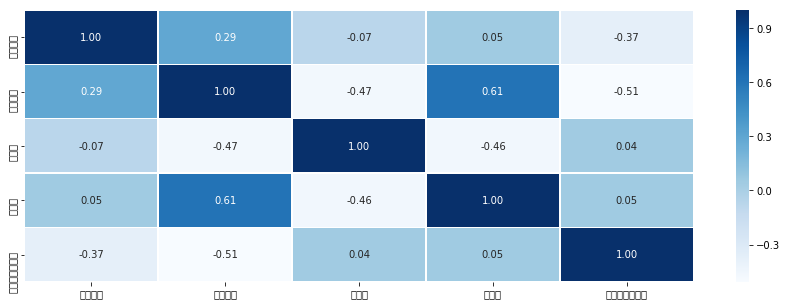

In [29]:
plt.figure(figsize=(15,5))
sns.heatmap(data=sun_weather[['총강수량','총습도량','총풍량','총기온','충전시간발전량']].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

In [30]:
sun_weather.columns

Index(['5Hr', '6Hr', '7Hr', '8Hr', '9Hr', '10Hr', '11Hr', '12Hr', '13Hr', '14Hr', '15Hr', '16Hr', '17Hr', '18Hr', '19Hr', '충전시간발전량', '강수량5hr', '강수량6hr', '강수량7hr', '강수량8hr', '강수량9hr', '강수량10hr', '강수량11hr', '강수량12hr', '강수량13hr', '강수량14hr', '강수량15hr', '강수량16hr', '강수량17hr', '강수량18hr', '강수량19hr', '강수량20hr', '습도5hr', '습도6hr', '습도7hr', '습도8hr', '습도9hr', '습도10hr', '습도11hr', '습도12hr', '습도13hr', '습도14hr', '습도15hr', '습도16hr', '습도17hr', '습도18hr', '습도19hr', '습도20hr', '풍속5hr', '풍속6hr', '풍속7hr', '풍속8hr', '풍속9hr', '풍속10hr', '풍속11hr', '풍속12hr', '풍속13hr', '풍속14hr', '풍속15hr', '풍속16hr', '풍속17hr', '풍속18hr', '풍속19hr', '풍속20hr', '기온5hr', '기온6hr', '기온7hr', '기온8hr', '기온9hr', '기온10hr', '기온11hr', '기온12hr', '기온13hr', '기온14hr', '기온15hr', '기온16hr', '기온17hr', '기온18hr', '기온19hr', '기온20hr', '총강수량', '총습도량', '총풍량', '총기온'], dtype='object')

In [31]:
sun_weather.shape

(382, 84)

## Exploring Data Analysis 결과

In [32]:
# 강수량과 습도만 발전량과 관계가 있어보임. 새롭게 모델짜보자

In [33]:
sun_weather.head()

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,충전시간발전량,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr,총강수량,총습도량,총풍량,총기온
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,1.3,1.1,7.3,1.5,0.2,0.0,140.5,3.200000,15.7,4.7,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.3,2.1,1.0,0.0,93.0,94.0,95.0,95.0,94.0,93.0,92.0,91.0,90.0,91.0,92.0,93.0,94.0,94.0,95.0,96.0,4.3,2.5,2.7,1.8,2.6,2.4,3.0,1.9,1.5,1.7,3.0,3.7,4.4,5.6,4.9,4.8,22.600000,22.200001,22.299999,23.900000,24.500000,24.299999,24.100000,23.6,24.299999,24.200001,24.700001,24.500000,24.200001,22.799999,22.400000,22.200001,23.900000,928.0,24.4,235.999999
2016-07-02,0.0,7.3,24.4,30.1,31.4,57.0,1.1,1.8,5.9,27.3,111.2,72.5,16.8,15.4,4.8,276.8,16.799999,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.1,0.0,0.0,96.0,96.0,94.0,93.0,95.0,94.0,95.0,96.0,95.0,96.0,95.0,95.0,90.0,96.0,95.0,96.0,1.6,1.6,3.0,4.9,5.1,2.9,1.3,0.5,1.1,3.5,2.2,1.5,2.6,1.6,1.6,0.3,22.799999,22.799999,23.200001,22.299999,21.200001,21.299999,20.299999,21.0,21.000000,20.400000,20.400000,20.600000,19.900000,20.700001,20.100000,20.000000,19.299999,950.0,25.5,216.299997
2016-07-03,0.0,0.0,14.0,16.9,39.7,17.1,10.4,53.9,23.1,3.3,0.0,0.0,0.0,4.6,0.1,107.8,0.000000,2.5,8.2,5.5,1.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,92.0,94.0,95.0,95.0,96.0,96.0,95.0,95.0,95.0,95.0,96.0,96.0,96.0,96.0,96.0,96.0,3.2,1.9,2.0,3.7,2.7,2.2,1.0,1.2,0.7,1.3,1.9,0.6,0.5,0.4,0.2,0.1,21.200001,21.000000,20.700001,20.500000,21.000000,20.799999,21.000000,21.4,21.700001,22.000000,22.100000,22.100000,22.200001,22.299999,22.200001,22.299999,18.900000,948.0,19.9,211.300002
2016-07-04,0.0,0.0,0.0,0.0,8.4,50.7,64.2,146.0,276.5,181.0,146.1,148.4,24.4,9.8,0.5,1012.9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,87.0,86.0,90.0,91.0,92.0,94.0,95.0,96.0,96.0,95.0,95.0,96.0,96.0,96.0,96.0,2.5,1.3,2.5,2.7,0.9,1.7,2.1,0.9,0.8,0.7,0.4,0.1,0.6,0.4,0.3,0.9,24.900000,26.000000,26.400000,24.700001,24.799999,23.900000,23.799999,23.6,23.600000,23.000000,22.900000,22.700001,22.700001,22.799999,22.600000,22.500000,0.000000,915.0,16.1,244.699999
2016-07-05,0.0,13.8,74.7,147.0,177.9,306.2,347.2,389.1,302.7,292.2,184.8,153.4,84.0,48.0,1.0,1975.6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.2,81.0,81.0,83.0,81.0,83.0,87.0,90.0,91.0,92.0,94.0,94.0,95.0,95.0,94.0,95.0,96.0,3.0,2.8,3.2,3.5,3.9,2.7,2.2,3.0,2.2,3.0,3.6,2.6,2.3,1.2,3.0,1.4,27.500000,27.700001,26.799999,27.900000,27.000000,26.400000,25.900000,25.6,24.900000,24.900000,24.500000,23.600000,24.400000,24.600000,24.500000,24.400000,0.000000,863.0,29.5,264.600000


In [34]:
sun_weather.shape

(382, 84)

In [35]:
sun_weather_2= sun_weather[['총강수량', '총습도량', '충전시간발전량']]

In [36]:
sun_weather_2.loc['2017-03-25']

총강수량         1.5
총습도량       870.0
충전시간발전량    209.7
Name: 2017-03-25 00:00:00, dtype: float64

In [37]:
# 382 * 0.7

In [38]:
train = sun_weather_2.loc[:'2017-03-25']
test = sun_weather_2.loc['2017-03-25':]

In [39]:
train.shape

(268, 3)

In [40]:
test.shape

(115, 3)

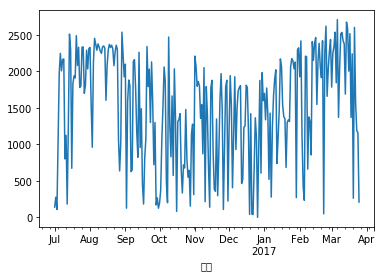

In [41]:
ax = train.충전시간발전량.plot()

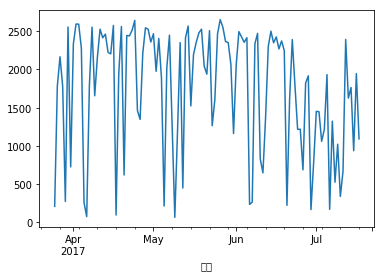

In [42]:
test.충전시간발전량.plot()

In [43]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [44]:
train.head()

,총강수량,총습도량,충전시간발전량
날짜,,,
2016-07-01,23.900000,928.0,140.5
2016-07-02,19.299999,950.0,276.8
2016-07-03,18.900000,948.0,107.8
2016-07-04,0.000000,915.0,1012.9
2016-07-05,0.000000,863.0,1975.6


In [45]:
test.head()

,총강수량,총습도량,충전시간발전량
날짜,,,
2017-03-25,1.5,870.0,209.7
2017-03-26,0.0,575.0,1784.8
2017-03-27,0.0,517.0,2165.7
2017-03-28,2.8,559.0,1779.9
2017-03-29,0.0,818.0,274.0


In [46]:
train_sc = sc.fit_transform(train)
# train_sc

In [47]:
test_sc = sc.transform(test)
# test_sc

In [48]:
test_sc.max()

0.9807407407407407

In [49]:
test_sc.min()

-0.062222222222222234

In [50]:
train_sc.max()

1.0000000000000002

In [51]:
train_sc.min()

0.0

In [52]:
train_sc

array([[0.38239999, 0.95703704, 0.05158906],
       [0.30879998, 0.98962963, 0.10195861],
       [0.3024    , 0.98666667, 0.0395048 ],
       [0.        , 0.93777778, 0.37398374],
       [0.        , 0.86074074, 0.72974871],
       [0.        , 0.87111111, 0.82904656],
       [0.        , 0.88296296, 0.74094605],
       [0.        , 0.8       , 0.79822616],
       [0.        , 0.89777778, 0.80121951],
       [0.        , 0.89777778, 0.29545455],
       [0.        , 0.89777778, 0.41437546],
       [0.296     , 1.        , 0.06714708],
       [0.        , 0.91407407, 0.46711013],
       [0.        , 0.68      , 0.92694013],
       [0.        , 0.74962963, 0.84682188],
       [0.        , 0.84592593, 0.24800443],
       [0.        , 0.81925926, 0.6763119 ],
       [0.        , 0.7362963 , 0.7154102 ],
       [0.        , 0.81481481, 0.70480414],
       [0.        , 0.79703704, 0.91895787],
       [0.        , 0.74962963, 0.768034  ],
       [0.        , 0.79259259, 0.86023651],
       [0.

In [53]:
# X, y값 나눠야하는데 array 형태니까~~
# 데이터프레임 형태로 일단 변형 ㄱㄱ

In [54]:
train_sc_df = pd.DataFrame(train_sc, columns= train.columns, index=train.index)
train_sc_df.head(2)

,총강수량,총습도량,충전시간발전량
날짜,,,
2016-07-01,0.3824,0.957037,0.051589
2016-07-02,0.3088,0.989630,0.101959


In [55]:
test_sc_df = pd.DataFrame(test_sc, columns= test.columns, index=test.index)
test_sc_df.head(2)

,총강수량,총습도량,충전시간발전량
날짜,,,
2017-03-25,0.024,0.871111,0.077162
2017-03-26,0.000,0.434074,0.659239


In [56]:
# test_sc_df.충전시간발전량

In [57]:
X_train = train_sc_df.dropna().drop('충전시간발전량', axis=1)
y_train = train_sc_df.dropna()[['충전시간발전량']]

In [58]:
X_train.head(1)

,총강수량,총습도량
날짜,,
2016-07-01,0.3824,0.957037


In [59]:
y_train.head(1)

,충전시간발전량
날짜,
2016-07-01,0.051589


In [60]:
X_test = test_sc_df.dropna().drop('충전시간발전량', axis=1)
# y_test = test_sc_df.dropna().충전시간발전량
y_test = test_sc_df.dropna()[['충전시간발전량']]

In [61]:
X_test.head(1)

,총강수량,총습도량
날짜,,
2017-03-25,0.024,0.871111


In [62]:
y_test.head(1)

,충전시간발전량
날짜,
2017-03-25,0.077162


In [63]:
# X값과 y 값 분리 끝~ 
# 근데 keras 돌리려면 3차원 형태로 바꿔줘야함. 
# 다시 array 형태로 바꿔야겠지?
# 데이터프레임 -> array 형태로 바꾸기 위해서 : value값만 추출 Go

In [64]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [65]:
X_train.shape

(268, 2)

In [66]:
X_test.shape

(115, 2)

In [67]:
# keras에서는 RNN계열의 모델을 트레이닝할 때 요구되는 데이터의 형식이 있다.
# 바로 3차원 데이터여야하며, 각각의 차원은(size, timestep, feature)
# timestep : 몇개의 특성으로 y 값을 맞출 거냐?

In [68]:
X_train_t = X_train.reshape(X_train.shape[0], 2, 1)
X_test_t = X_test.reshape(X_test.shape[0], 2, 1)

In [69]:
X_train_t.shape

(268, 2, 1)

In [70]:
X_test_t.shape

(115, 2, 1)

In [166]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [167]:
X_train_t.shape

(267, 27, 1)

In [168]:
K.clear_session()
model = Sequential()
model.add(LSTM(20, input_shape=(27,1))) # shape는 차원맞추는 것
model.add(Dense(1))  #Dense : output 개수 (이거 아닌듯!) -> layer의 갯수인

In [ ]:
# model50 = Sequential()
# model50.add(Dense(27, input_dim = 27, activation = 'tanh'))
# model50.add(Dropout(0.2))
# model50.add(Dense(300, activation = 'tanh'))
# model50.add(Dropout(0.2))
# model50.add(Dense(500, activation = 'tanh'))
# model50.add(Dropout(0.2))
# model50.add(Dense(300, activation = 'tanh'))
# model50.add(Dropout(0.2))
# model50.add(Dense(1))
# # model50.compile(loss='mean_squared_error', optimizer='rmsprop')
# model50.compile(loss='mean_squared_error', optimizer='adam')

# hist = model50.fit(X_train, y_train, epochs=50, batch_size=10)
# model50.evaluate(X_test, y_test)
# yhat = model50.predict(X_test)
# rmse2 = sqrt(mean_squared_error(y_test, yhat))
# print('Test RMSE: %.3f' % rmse2)


In [170]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_t, y_train, epochs = 100, batch_size=30, verbose=1)

Epoch 1/100
267/267 [==============================] - 1s 3ms/step - loss: 0.0706
Epoch 2/100
267/267 [==============================] - 0s 370us/step - loss: 0.0688
Epoch 3/100
267/267 [==============================] - 0s 366us/step - loss: 0.0678
Epoch 4/100
267/267 [==============================] - 0s 374us/step - loss: 0.0666
Epoch 5/100
267/267 [==============================] - 0s 381us/step - loss: 0.0661
Epoch 6/100
267/267 [==============================] - 0s 381us/step - loss: 0.0650
Epoch 7/100
267/267 [==============================] - 0s 385us/step - loss: 0.0650
Epoch 8/100
267/267 [==============================] - 0s 381us/step - loss: 0.0643
Epoch 9/100
267/267 [==============================] - 0s 385us/step - loss: 0.0636
Epoch 10/100
267/267 [==============================] - 0s 370us/step - loss: 0.0626
Epoch 11/100
267/267 [==============================] - 0s 392us/step - loss: 0.0619
Epoch 12/100
267/267 [==============================] - 0s 388us/step - loss

267/267 [==============================] - 0s 478us/step - loss: 0.0450
Epoch 98/100
267/267 [==============================] - 0s 508us/step - loss: 0.0438
Epoch 99/100
267/267 [==============================] - 0s 542us/step - loss: 0.0434
Epoch 100/100
267/267 [==============================] - 0s 545us/step - loss: 0.0439


In [171]:
y_pred = model.predict(X_test_t)

In [76]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [77]:
from math import sqrt

In [78]:
rmse = sqrt(mean_squared_error(y_test, y_pred))

In [79]:
rmse

0.24823466430381122

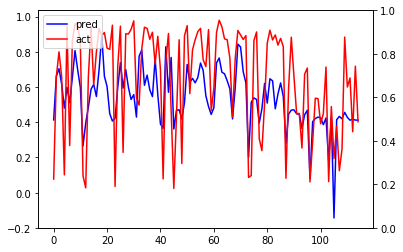

In [80]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

pred = y_pred

loss_ax.plot(pred, 'b', label='pred')

loss_ax.plot(y_test, 'r', label='act')

loss_ax.legend(loc='upper left')

plt.show()

In [81]:
model50 = Sequential()
model50.add(Dense(2, input_dim = 2, activation = 'tanh'))
model50.add(Dropout(0.2))
model50.add(Dense(300, activation = 'tanh'))
model50.add(Dropout(0.2))
model50.add(Dense(500, activation = 'tanh'))
model50.add(Dropout(0.2))
model50.add(Dense(300, activation = 'tanh'))
model50.add(Dropout(0.2))
model50.add(Dense(1))
# model50.compile(loss='mean_squared_error', optimizer='rmsprop')
model50.compile(loss='mean_squared_error', optimizer='adam')
hist = model50.fit(X_train, y_train, epochs=50, batch_size=10)

Epoch 1/50
268/268 [==============================] - 1s 2ms/step - loss: 0.2578
Epoch 2/50
268/268 [==============================] - 0s 480us/step - loss: 0.1019
Epoch 3/50
268/268 [==============================] - 0s 488us/step - loss: 0.0948
Epoch 4/50
268/268 [==============================] - 0s 554us/step - loss: 0.0854
Epoch 5/50
268/268 [==============================] - 0s 502us/step - loss: 0.0858
Epoch 6/50
268/268 [==============================] - 0s 469us/step - loss: 0.0831
Epoch 7/50
268/268 [==============================] - 0s 514us/step - loss: 0.0777
Epoch 8/50
268/268 [==============================] - 0s 484us/step - loss: 0.0787
Epoch 9/50
268/268 [==============================] - 0s 458us/step - loss: 0.0764
Epoch 10/50
268/268 [==============================] - 0s 447us/step - loss: 0.0747
Epoch 11/50
268/268 [==============================] - 0s 439us/step - loss: 0.0901
Epoch 12/50
268/268 [==============================] - 0s 439us/step - loss: 0.0696
Epo

In [82]:
model50.evaluate(X_test, y_test)
yhat = model50.predict(X_test)
rmse2 = sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse2)

115/115 [==============================] - 0s 685us/step
Test RMSE: 0.254


In [83]:
from math import sqrt

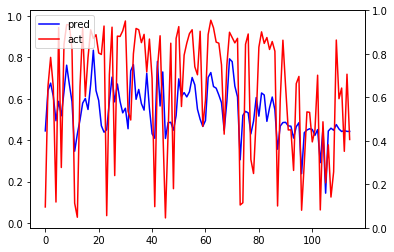

In [84]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

pred = y_pred

loss_ax.plot(yhat, 'b', label='pred')

loss_ax.plot(y_test, 'r', label='act')

loss_ax.legend(loc='upper left')

plt.show()

## feature 수가 너무 적어서 그런지 모델의 결과가 안좋다

In [85]:
sun_weather.head()

,5Hr,6Hr,7Hr,8Hr,9Hr,10Hr,11Hr,12Hr,13Hr,14Hr,15Hr,16Hr,17Hr,18Hr,19Hr,충전시간발전량,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도5hr,습도6hr,습도7hr,습도8hr,습도9hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,풍속5hr,풍속6hr,풍속7hr,풍속8hr,풍속9hr,풍속10hr,풍속11hr,풍속12hr,풍속13hr,풍속14hr,풍속15hr,풍속16hr,풍속17hr,풍속18hr,풍속19hr,풍속20hr,기온5hr,기온6hr,기온7hr,기온8hr,기온9hr,기온10hr,기온11hr,기온12hr,기온13hr,기온14hr,기온15hr,기온16hr,기온17hr,기온18hr,기온19hr,기온20hr,총강수량,총습도량,총풍량,총기온
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.0,2.5,36.9,44.4,29.2,59.3,33.9,9.2,28.4,1.3,1.1,7.3,1.5,0.2,0.0,140.5,3.200000,15.7,4.7,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.3,2.1,1.0,0.0,93.0,94.0,95.0,95.0,94.0,93.0,92.0,91.0,90.0,91.0,92.0,93.0,94.0,94.0,95.0,96.0,4.3,2.5,2.7,1.8,2.6,2.4,3.0,1.9,1.5,1.7,3.0,3.7,4.4,5.6,4.9,4.8,22.600000,22.200001,22.299999,23.900000,24.500000,24.299999,24.100000,23.6,24.299999,24.200001,24.700001,24.500000,24.200001,22.799999,22.400000,22.200001,23.900000,928.0,24.4,235.999999
2016-07-02,0.0,7.3,24.4,30.1,31.4,57.0,1.1,1.8,5.9,27.3,111.2,72.5,16.8,15.4,4.8,276.8,16.799999,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.1,0.0,0.0,96.0,96.0,94.0,93.0,95.0,94.0,95.0,96.0,95.0,96.0,95.0,95.0,90.0,96.0,95.0,96.0,1.6,1.6,3.0,4.9,5.1,2.9,1.3,0.5,1.1,3.5,2.2,1.5,2.6,1.6,1.6,0.3,22.799999,22.799999,23.200001,22.299999,21.200001,21.299999,20.299999,21.0,21.000000,20.400000,20.400000,20.600000,19.900000,20.700001,20.100000,20.000000,19.299999,950.0,25.5,216.299997
2016-07-03,0.0,0.0,14.0,16.9,39.7,17.1,10.4,53.9,23.1,3.3,0.0,0.0,0.0,4.6,0.1,107.8,0.000000,2.5,8.2,5.5,1.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,92.0,94.0,95.0,95.0,96.0,96.0,95.0,95.0,95.0,95.0,96.0,96.0,96.0,96.0,96.0,96.0,3.2,1.9,2.0,3.7,2.7,2.2,1.0,1.2,0.7,1.3,1.9,0.6,0.5,0.4,0.2,0.1,21.200001,21.000000,20.700001,20.500000,21.000000,20.799999,21.000000,21.4,21.700001,22.000000,22.100000,22.100000,22.200001,22.299999,22.200001,22.299999,18.900000,948.0,19.9,211.300002
2016-07-04,0.0,0.0,0.0,0.0,8.4,50.7,64.2,146.0,276.5,181.0,146.1,148.4,24.4,9.8,0.5,1012.9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,87.0,86.0,90.0,91.0,92.0,94.0,95.0,96.0,96.0,95.0,95.0,96.0,96.0,96.0,96.0,2.5,1.3,2.5,2.7,0.9,1.7,2.1,0.9,0.8,0.7,0.4,0.1,0.6,0.4,0.3,0.9,24.900000,26.000000,26.400000,24.700001,24.799999,23.900000,23.799999,23.6,23.600000,23.000000,22.900000,22.700001,22.700001,22.799999,22.600000,22.500000,0.000000,915.0,16.1,244.699999
2016-07-05,0.0,13.8,74.7,147.0,177.9,306.2,347.2,389.1,302.7,292.2,184.8,153.4,84.0,48.0,1.0,1975.6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.2,81.0,81.0,83.0,81.0,83.0,87.0,90.0,91.0,92.0,94.0,94.0,95.0,95.0,94.0,95.0,96.0,3.0,2.8,3.2,3.5,3.9,2.7,2.2,3.0,2.2,3.0,3.6,2.6,2.3,1.2,3.0,1.4,27.500000,27.700001,26.799999,27.900000,27.000000,26.400000,25.900000,25.6,24.900000,24.900000,24.500000,23.600000,24.400000,24.600000,24.500000,24.400000,0.000000,863.0,29.5,264.600000


In [86]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback): 
    def init(self): 
        self.losses = [] 
    def on_epoch_end(self, batch, logs={}): 
        self.losses.append(logs.get('loss')) 

In [87]:
history = LossHistory()  
history.init() 
 
model50.fit(X_train, y_train, epochs=100, batch_size=30, verbose=1, callbacks=[history]) 

Epoch 1/100
268/268 [==============================] - 0s 171us/step - loss: 0.0628
Epoch 2/100
268/268 [==============================] - 0s 171us/step - loss: 0.0582
Epoch 3/100
268/268 [==============================] - 0s 190us/step - loss: 0.0610
Epoch 4/100
268/268 [==============================] - 0s 208us/step - loss: 0.0576
Epoch 5/100
268/268 [==============================] - 0s 205us/step - loss: 0.0550
Epoch 6/100
268/268 [==============================] - 0s 197us/step - loss: 0.0576
Epoch 7/100
268/268 [==============================] - 0s 227us/step - loss: 0.0582
Epoch 8/100
268/268 [==============================] - 0s 205us/step - loss: 0.0549
Epoch 9/100
268/268 [==============================] - 0s 220us/step - loss: 0.0605
Epoch 10/100
268/268 [==============================] - 0s 227us/step - loss: 0.0553
Epoch 11/100
268/268 [==============================] - 0s 220us/step - loss: 0.0585
Epoch 12/100
268/268 [==============================] - 0s 201us/step - lo

268/268 [==============================] - 0s 238us/step - loss: 0.0544
Epoch 98/100
268/268 [==============================] - 0s 257us/step - loss: 0.0525
Epoch 99/100
268/268 [==============================] - 0s 257us/step - loss: 0.0571
Epoch 100/100
268/268 [==============================] - 0s 257us/step - loss: 0.0542


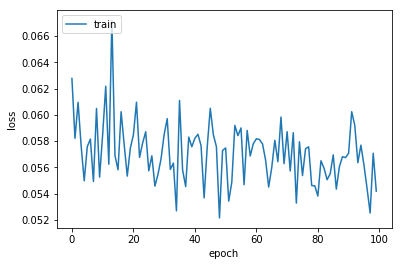

In [88]:
# 학습 시각화 
%matplotlib inline 
import matplotlib.pyplot as plt 
 
plt.plot(history.losses) 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train'], loc='upper left')
plt.show() 

*  차라리 컬럼들(총습도량, 총강수량)을 합치지 않고 그냥 결과를 내보자!

In [92]:
sun_weather.columns

Index(['5Hr', '6Hr', '7Hr', '8Hr', '9Hr', '10Hr', '11Hr', '12Hr', '13Hr', '14Hr', '15Hr', '16Hr', '17Hr', '18Hr', '19Hr', '충전시간발전량', '강수량5hr', '강수량6hr', '강수량7hr', '강수량8hr', '강수량9hr', '강수량10hr', '강수량11hr', '강수량12hr', '강수량13hr', '강수량14hr', '강수량15hr', '강수량16hr', '강수량17hr', '강수량18hr', '강수량19hr', '강수량20hr', '습도5hr', '습도6hr', '습도7hr', '습도8hr', '습도9hr', '습도10hr', '습도11hr', '습도12hr', '습도13hr', '습도14hr', '습도15hr', '습도16hr', '습도17hr', '습도18hr', '습도19hr', '습도20hr', '풍속5hr', '풍속6hr', '풍속7hr', '풍속8hr', '풍속9hr', '풍속10hr', '풍속11hr', '풍속12hr', '풍속13hr', '풍속14hr', '풍속15hr', '풍속16hr', '풍속17hr', '풍속18hr', '풍속19hr', '풍속20hr', '기온5hr', '기온6hr', '기온7hr', '기온8hr', '기온9hr', '기온10hr', '기온11hr', '기온12hr', '기온13hr', '기온14hr', '기온15hr', '기온16hr', '기온17hr', '기온18hr', '기온19hr', '기온20hr', '총강수량', '총습도량', '총풍량', '총기온'], dtype='object')

In [96]:
sun_weather_3 = sun_weather[['강수량5hr', '강수량6hr', '강수량7hr', '강수량8hr', '강수량9hr', '강수량10hr', '강수량11hr', '강수량12hr', '강수량13hr', '강수량14hr', '강수량15hr', '강수량16hr', '강수량17hr', '강수량18hr', '강수량19hr', '강수량20hr','습도10hr', '습도11hr', '습도12hr', '습도13hr', '습도14hr', '습도15hr', '습도16hr', '습도17hr', '습도18hr', '습도19hr', '습도20hr','충전시간발전량']]

In [97]:
sun_weather_3.head()

,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,충전시간발전량
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,3.200000,15.7,4.7,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.3,2.1,1.0,0.0,93.0,92.0,91.0,90.0,91.0,92.0,93.0,94.0,94.0,95.0,96.0,140.5
2016-07-02,16.799999,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.1,0.0,0.0,94.0,95.0,96.0,95.0,96.0,95.0,95.0,90.0,96.0,95.0,96.0,276.8
2016-07-03,0.000000,2.5,8.2,5.5,1.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,96.0,95.0,95.0,95.0,95.0,96.0,96.0,96.0,96.0,96.0,96.0,107.8
2016-07-04,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,94.0,95.0,96.0,96.0,95.0,95.0,96.0,96.0,96.0,96.0,1012.9
2016-07-05,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.2,87.0,90.0,91.0,92.0,94.0,94.0,95.0,95.0,94.0,95.0,96.0,1975.6


In [100]:
len(sun_weather_3)*0.7

267.4

In [102]:
train = sun_weather_3.iloc[:267]
test =  sun_weather_3.iloc[267:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [109]:
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [110]:
train_sc

array([[0.1904762 , 1.        , 0.57317073, ..., 0.98305085, 0.98275862,
        0.05158906],
       [1.        , 0.15923567, 0.        , ..., 0.98305085, 0.98275862,
        0.10195861],
       [0.        , 0.15923567, 1.        , ..., 1.        , 0.98275862,
        0.0395048 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.37288136, 0.4137931 ,
        0.57764228],
       [0.        , 0.        , 0.        , ..., 0.23728814, 0.17241379,
        0.43895048],
       [0.        , 0.        , 0.        , ..., 0.83050847, 0.82758621,
        0.42793792]])

In [111]:
train_sc_df = pd.DataFrame(train_sc, columns= train.columns, index=train.index)
train_sc_df.head(2)

,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,충전시간발전량
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.190476,1.000000,0.573171,0.0,0.0,0.0,0.028302,0.0,0.0,0.0,0.0,0.0,0.046154,0.201923,0.188679,0.0,0.954545,0.938462,0.888889,0.883333,0.901639,0.933333,0.950820,0.96875,0.969231,0.983051,0.982759,0.051589
2016-07-02,1.000000,0.159236,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.076923,0.105769,0.000000,0.0,0.969697,0.984615,0.968254,0.966667,0.983607,0.983333,0.983607,0.90625,1.000000,0.983051,0.982759,0.101959


In [112]:
test_sc_df = pd.DataFrame(test_sc, columns= test.columns, index=test.index)
test_sc_df.head(2)

,강수량5hr,강수량6hr,강수량7hr,강수량8hr,강수량9hr,강수량10hr,강수량11hr,강수량12hr,강수량13hr,강수량14hr,강수량15hr,강수량16hr,강수량17hr,강수량18hr,강수량19hr,강수량20hr,습도10hr,습도11hr,습도12hr,습도13hr,습도14hr,습도15hr,습도16hr,습도17hr,습도18hr,습도19hr,습도20hr,충전시간발전량
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-25,0.035714,0.031847,0.04878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.803030,0.846154,0.857143,0.85,0.852459,0.866667,0.868852,0.890625,0.861538,0.796610,0.844828,0.077162
2017-03-26,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.378788,0.461538,0.539683,0.60,0.639344,0.666667,0.704918,0.781250,0.784615,0.762712,0.672414,0.659239


In [150]:
X_train = train_sc_df.drop('충전시간발전량', axis=1)
y_train = train_sc_df[['충전시간발전량']]

In [151]:
X_test = test_sc_df.drop('충전시간발전량', axis=1)
y_test = test_sc_df[['충전시간발전량']]

In [152]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from math import sqrt

In [153]:
X_train.shape

(267, 27)

In [154]:
# X_train = X_train.reshape(X_train.shape[0], 27, 1)
# X_test = X_test.reshape(X_test.shape[0], 27, 1)

In [155]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [156]:
X_train.shape

(267, 27)

In [158]:
X_train_t = X_train.reshape(X_train.shape[0], 27, 1)
X_test_t = X_test.reshape(X_test.shape[0], 27, 1)

In [160]:
X_train_t.shape

(267, 27, 1)

In [161]:
K.clear_session()
model = Sequential()
model.add(LSTM(20, input_shape=(27,1))) 
# shape는 차원맞추는 것
# 데이터프레임은 그냥 1차원이다
# 그러니 array 변환해서 2차원으로 만들장

model.add(Dense(1))  #Dense : output 개수 

In [163]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_t, y_train, epochs = 100, batch_size=30, verbose=1)

Epoch 1/100
267/267 [==============================] - 1s 3ms/step - loss: 0.0499
Epoch 2/100
267/267 [==============================] - 0s 392us/step - loss: 0.0493
Epoch 3/100
267/267 [==============================] - 0s 396us/step - loss: 0.0479
Epoch 4/100
267/267 [==============================] - 0s 377us/step - loss: 0.0521
Epoch 5/100
267/267 [==============================] - 0s 381us/step - loss: 0.0500
Epoch 6/100
267/267 [==============================] - 0s 374us/step - loss: 0.0486
Epoch 7/100
267/267 [==============================] - 0s 377us/step - loss: 0.0489
Epoch 8/100
267/267 [==============================] - 0s 381us/step - loss: 0.0502
Epoch 9/100
267/267 [==============================] - 0s 385us/step - loss: 0.0493
Epoch 10/100
267/267 [==============================] - 0s 411us/step - loss: 0.0472
Epoch 11/100
267/267 [==============================] - 0s 411us/step - loss: 0.0471
Epoch 12/100
267/267 [==============================] - 0s 374us/step - loss

267/267 [==============================] - 0s 489us/step - loss: 0.0446
Epoch 98/100
267/267 [==============================] - 0s 456us/step - loss: 0.0434
Epoch 99/100
267/267 [==============================] - 0s 463us/step - loss: 0.0465
Epoch 100/100
267/267 [==============================] - 0s 452us/step - loss: 0.0444


In [ ]:
model50 = Sequential()
model50.add(Dense(27, input_dim = 27, activation = 'tanh'))
model50.add(Dropout(0.2))
model50.add(Dense(300, activation = 'tanh'))
model50.add(Dropout(0.2))
model50.add(Dense(500, activation = 'tanh'))
model50.add(Dropout(0.2))
model50.add(Dense(300, activation = 'tanh'))
model50.add(Dropout(0.2))
model50.add(Dense(1))
# model50.compile(loss='mean_squared_error', optimizer='rmsprop')
model50.compile(loss='mean_squared_error', optimizer='adam')
hist = model50.fit(X_train, y_train, epochs=50, batch_size=10)

model50.evaluate(X_test, y_test)
yhat = model50.predict(X_test)

In [174]:
rmse2 = sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse2)

Test RMSE: 0.255


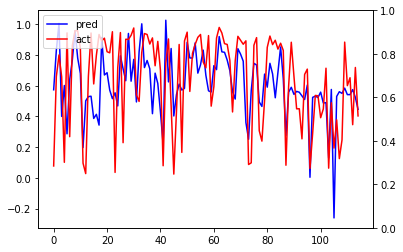

In [173]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

pred = y_pred

loss_ax.plot(yhat, 'b', label='pred')

loss_ax.plot(y_test, 'r', label='act')

loss_ax.legend(loc='upper left')

plt.show()